In [1]:
using Plots
using Distributions
using HypothesisTests
using Random

In [2]:
liczba_szkod = Dict(0 => 3437,
                1 => 522,
                2 => 40,
                3 => 2,
                4 => 0, 
                5 => 0);

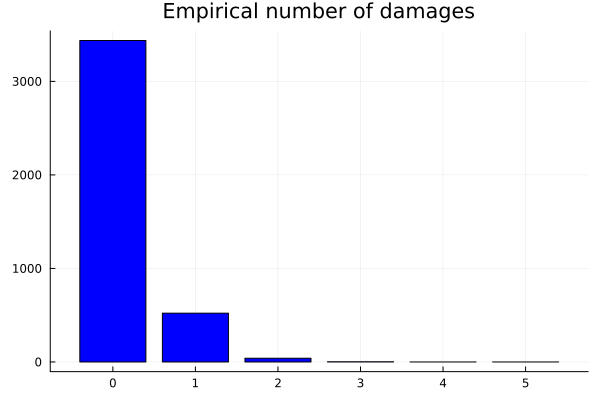

In [3]:
# Average number of damages:
liczba_polis = sum(values(liczba_szkod))
srednia_liczba_szkod = (sum([x * y for (x, y) in liczba_szkod]) / 
                        liczba_polis)

# Does the number of damages actually have a Poisson distribution?
poiss = Poisson(srednia_liczba_szkod)
k = length(liczba_szkod)-1
poisson_test = pdf.(poiss, 0:k) * liczba_polis

bar(liczba_szkod, fillcolor = :blue, legend=false, title= "Empirical number of damages")

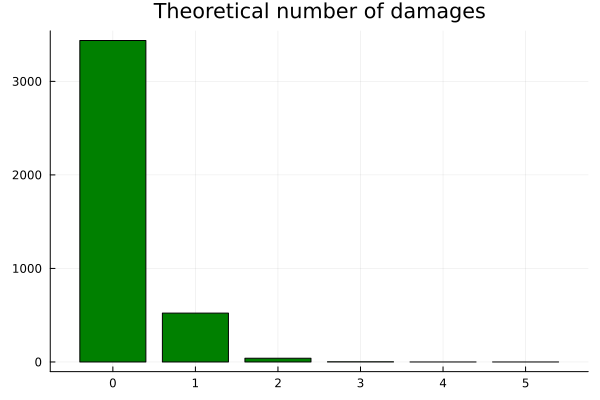

In [4]:
bar(0:k, poisson_test, fillcolor = :green, legend = false, title = "Theoretical number of damages")

In [5]:
# Chi-square test
χ = ChisqTest([liczba_szkod[i] for i in 0:k],poisson_test/sum(poisson_test));
pval = pvalue(χ)
println("p-value=",pval)
if pval > 0.05
    print("No reason to reject the null hypothesis")
else
    print("The null hypothesis should be rejected")
end

p-value=0.9999022759058723
No reason to reject the null hypothesis

## Amount of damage

In [6]:
szkody = [parse(Int,x[2]) for x in split.(readlines("./szkody.txt"), ';')];

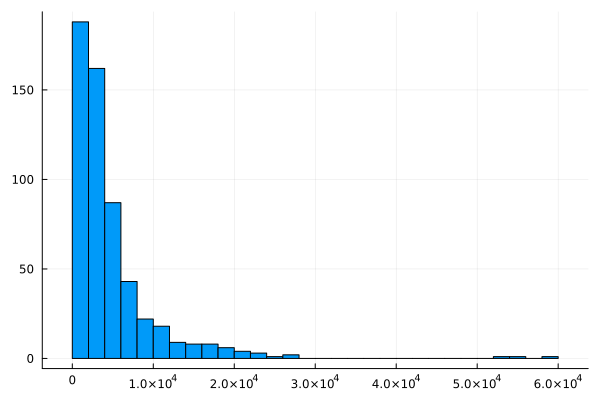

In [7]:
histogram(szkody, legend = false, bins = 50)

In [8]:
println("Average size of damage: ", round(mean(szkody)))

Average size of damage: 4742.0


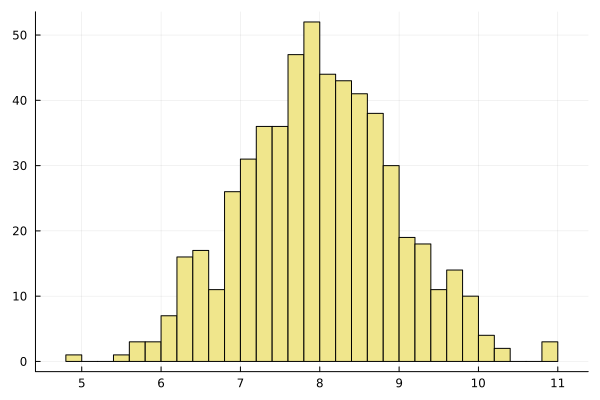

In [9]:
# The volume of damage has a log-normal distribution:
szkody_ln = log.(szkody);
histogram(szkody_ln, fillcolor=:khaki, legend = false, bins = 50)

In [10]:
# Kolmogorov-Smirnov test
kstest = ExactOneSampleKSTest(szkody_ln, Normal(mean(szkody_ln), std(szkody_ln)))
kspval = pvalue(kstest)
if kspval > 0.05
    println("p-value is:", kspval, 
           "\nThere are therefore no reasons to reject the hypothesis " *
           "of log-normality of the distribution of the variable")
else
    println("reject the null hypothesis")
end

p-value is:0.9970804174500004
There are therefore no reasons to reject the hypothesis of log-normality of the distribution of the variable


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\mikol\.julia\packages\HypothesisTests\zKkJv\src\kolmogorov_smirnov.jl:68


In [11]:
# Damage volume parameters needed for simulation:
SR_SZKODA_LN = mean(szkody_ln)
STD_SZKODA_LN = std(szkody_ln);

In [12]:
LICZBA_POWTORZEN = 100 
LICZBA_KLIENTOW = 100
HORYZONT = 2

2

## Simulation model

In [13]:
function model(liczba_klientow::S, 
                srednia_liczba_szkod::T, 
                sr_szkoda_ln::T, 
                std_szkoda_ln::T, 
                horyzont::S, 
                nadwyzka::T, 
                skladka::T;
                seed::S=-1) where {T<:AbstractFloat, S<:Int}

    seed == -1 || Random.seed!(seed) 

    # We define customer contract dates in the simulation:
    daty_umow = [rand(1:365) for i in 1:liczba_klientow]
    kalendarz_wplat = zeros(Int,365)
    for dataUmowy in daty_umow
        kalendarz_wplat[dataUmowy] += 1
    end
    # We count the number of damages per customer:
    liczba_szkod_klienta = rand(Poisson(srednia_liczba_szkod),liczba_klientow)
    
    # We set payout dates for all policies:
    kalendarz_wyplat = zeros(Int,365*horyzont) 
    for k in 1:liczba_klientow
        for s in 1:liczba_szkod_klienta[k]
            data_wyplaty = daty_umow[k] + rand(1:365)
            kalendarz_wyplat[data_wyplaty] += 1
        end
    end
    
    
    # Analysis of company performance for a given time horizon and damage data:
    for dzien in 1:365*horyzont
        dzien ≤ 364 && (nadwyzka += kalendarz_wplat[dzien] * skladka)
        liczba_wyplat = kalendarz_wyplat[dzien]
        odszkodowania = sum(exp.(rand(Normal(sr_szkoda_ln,std_szkoda_ln),liczba_wyplat)))
        nadwyzka -= odszkodowania
        nadwyzka ≤ 0 && return nadwyzka
    end
    return nadwyzka
end

model (generic function with 1 method)

In [14]:
function wywolanie(nadwyzka::T, skladka::T, liczba_powtorzen::S, 
              liczba_klientow::S, srednia_liczba_szkod::T, 
              sr_szkoda_ln::T, std_szkoda_ln::T, horyzont::S) where {T<:AbstractFloat,S<:Int}
    wynik = []
    for seed in 1:liczba_powtorzen
        
        push!(wynik, model(liczba_klientow, srednia_liczba_szkod , 
                           sr_szkoda_ln, std_szkoda_ln, horyzont, 
                           nadwyzka, skladka, seed = seed))
    end

    return (liczba_ruin = sum(wynik.<0), p_bankructwa = sum(wynik.<0)/liczba_powtorzen, 
            sredni_wynik = mean(wynik[wynik.>0]))
end   

wywolanie (generic function with 1 method)

## Symulacja

In [15]:
nadwyzka = 10000.0:10000.0:10000.0
skladka = 500.0:100.0:1000.0

500.0:100.0:1000.0

In [16]:
sr_wynik = []
prawd_bankr = []
liczba_ruin = [] 

for nd in nadwyzka, skl in skladka
    wynik = wywolanie(nd, skl, 
            LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)
    push!(liczba_ruin, wynik.liczba_ruin)
    push!(prawd_bankr, wynik.p_bankructwa)
    push!(sr_wynik,wynik.sredni_wynik)
    println("Nadwyzka: ", nd, " Skladka: ", skl, 
              " Number of ruins: ", wynik.liczba_ruin, " Average result: ",
              round(wynik.sredni_wynik), " Probability_of_bankruptcy: ", wynik.p_bankructwa)
end

Nadwyzka: 10000.0 Skladka: 500.0 Number of ruins: 60 Average result: 15777.0 Probability_of_bankruptcy: 0.6
Nadwyzka: 10000.0 Skladka: 600.0 Number of ruins: 49 Average result: 21174.0 Probability_of_bankruptcy: 0.49
Nadwyzka: 10000.0 Skladka: 700.0 Number of ruins: 35 Average result: 25476.0 Probability_of_bankruptcy: 0.35
Nadwyzka: 10000.0 Skladka: 800.0 Number of ruins: 26 Average result: 31786.0 Probability_of_bankruptcy: 0.26
Nadwyzka: 10000.0 Skladka: 900.0 Number of ruins: 19 Average result: 38709.0 Probability_of_bankruptcy: 0.19
Nadwyzka: 10000.0 Skladka: 1000.0 Number of ruins: 12 Average result: 45201.0 Probability_of_bankruptcy: 0.12


## 1. What OC premium should be set so that the probability of ruin is less than 0.01? (analysis of 1 parameter)

Nadwyzka: 10000.0 Skladka: 500.0 Number of ruins: 60 Average result: 15777.0 Probability_of_bankruptcy: 0.6
Nadwyzka: 10000.0 Skladka: 600.0 Number of ruins: 49 Average result: 21174.0 Probability_of_bankruptcy: 0.49
Nadwyzka: 10000.0 Skladka: 700.0 Number of ruins: 35 Average result: 25476.0 Probability_of_bankruptcy: 0.35
Nadwyzka: 10000.0 Skladka: 800.0 Number of ruins: 26 Average result: 31786.0 Probability_of_bankruptcy: 0.26
Nadwyzka: 10000.0 Skladka: 900.0 Number of ruins: 19 Average result: 38709.0 Probability_of_bankruptcy: 0.19
Nadwyzka: 10000.0 Skladka: 1000.0 Number of ruins: 12 Average result: 45201.0 Probability_of_bankruptcy: 0.12
Nadwyzka: 10000.0 Skladka: 1100.0 Number of ruins: 7 Average result: 52563.0 Probability_of_bankruptcy: 0.07
Nadwyzka: 10000.0 Skladka: 1200.0 Number of ruins: 3 Average result: 60274.0 Probability_of_bankruptcy: 0.03
Nadwyzka: 10000.0 Skladka: 1300.0 Number of ruins: 2 Average result: 69542.0 Probability_of_bankruptcy: 0.02
Nadwyzka: 10000.0 S

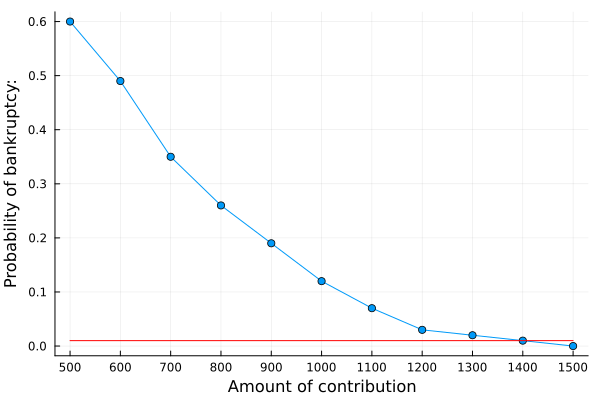

In [17]:
nadwyzka = 10000.0:10000.0:10000.0
skladka = 500.0:100.0:1500.0

sr_wynik = []
prawd_bankr = []
liczba_ruin = [] 

for nd in nadwyzka, skl in skladka
    wynik = wywolanie(nd, skl, 
            LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)
    push!(liczba_ruin, wynik.liczba_ruin)
    push!(prawd_bankr, wynik.p_bankructwa)
    push!(sr_wynik,wynik.sredni_wynik)
    println("Nadwyzka: ", nd, " Skladka: ", skl, 
              " Number of ruins: ", wynik.liczba_ruin, " Average result: ",
              round(wynik.sredni_wynik), " Probability_of_bankruptcy: ", wynik.p_bankructwa)
end

plot(collect(skladka), prawd_bankr, markershape=:circle,
ylabel = "Probability of bankruptcy:",
xlabel = "Amount of contribution",
legend = false) 

x = collect(500:0.1:1500)
y = fill(0.01, length(x))
plot!(x, y, line=:line, linecolor=:red, legend=false)
xticks!(collect(500.0:100.0:1500.0))

In [18]:
# The contribution should be 1400

## 2. what should the surplus and contribution be so that the probability of ruin is less than 0.01? (analysis of 2 parameters)

In [19]:
using DataFrames
using StatsPlots

nadwyzka = 10000.0:1000.0:50000.0
skladka = 500.0:100.0:1000.0

df = DataFrame(Nadwyzka = Float64[], Skladka = Float64[], Prawd_bankr = Float64[])

for nd in nadwyzka, skl in skladka
    wynik = wywolanie(nd, skl, 
            LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)    
    push!(df, (nd, skl, wynik.p_bankructwa))
end

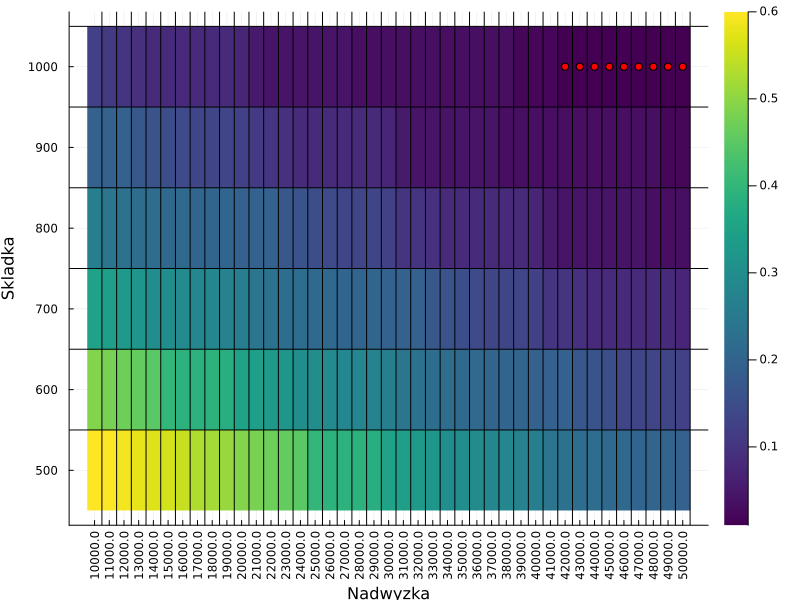

In [20]:
using Plots
using DataFrames
using StatsPlots
using StatsBase
plot_size = (800, 600)

# Specify columns for x-axis and y-axis
x_col = :Nadwyzka
y_col = :Skladka
z_col = :Prawd_bankr

# Binning the data
x_nadwyzka = collect(nadwyzka)
y_skladka = collect(skladka)
z_prob = collect(df.Prawd_bankr)
mat = reshape(z_prob, length(y_skladka), length(x_nadwyzka))
        
# Plotting the heatmap x_nadwyzka
heatmap(x_nadwyzka, y_skladka, mat ,xlabel = string(x_col),
        ylabel = string(y_col), color = :viridis, yrotation=0, xrotation=90)

xticks!(10000.0:1000.0:50000.0, [string(y) for y in 10000.0:1000.0:50000.0])
plot!(legend=false, size=plot_size)

vline!([nadwyzka .+ 500], color="black")
hline!([skladka .+ 50], color="black")

indices = findall(x -> x <= 0.01, mat)

# Get the corresponding x and y values for those indices
x_values = y_skladka[[i[1] for i in indices]] 
y_values = x_nadwyzka[[i[2] for i in indices]]

scatter!(y_values, x_values, color=:red, marker=:circle)

In [21]:
# Red dots indicate a probability of ruin less than or equal to 0.01 

## 3. when will the final surplus equal the initial surplus? Estimate based on the regression model.

#### a) First solution

In [22]:
nadwyzka = 100000.0
skladki = 100.0:10.0:5000.0
skladka_finalna = 0.0

for skladka in skladki
    wynik = wywolanie(nadwyzka, skladka, 
            LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)
    
    if wynik.sredni_wynik > nadwyzka
        skladka_finalna = skladka
        break
    end
end
println("Składka finalna: ",skladka_finalna)

Składka finalna: 720.0


#### b) Second solution (using a regression model)

In [23]:
nadwyzka = 100000.0
skladki = 100.0:10.0:5000.0

df = DataFrame(Skladka = Float64[], Roznica = Float64[])

for nd in nadwyzka, skl in skladki
    wynik = wywolanie(nd, skl, 
            LICZBA_POWTORZEN, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)   
    push!(df, (skl, wynik.sredni_wynik - nd))
end


Final contribution: 720.0


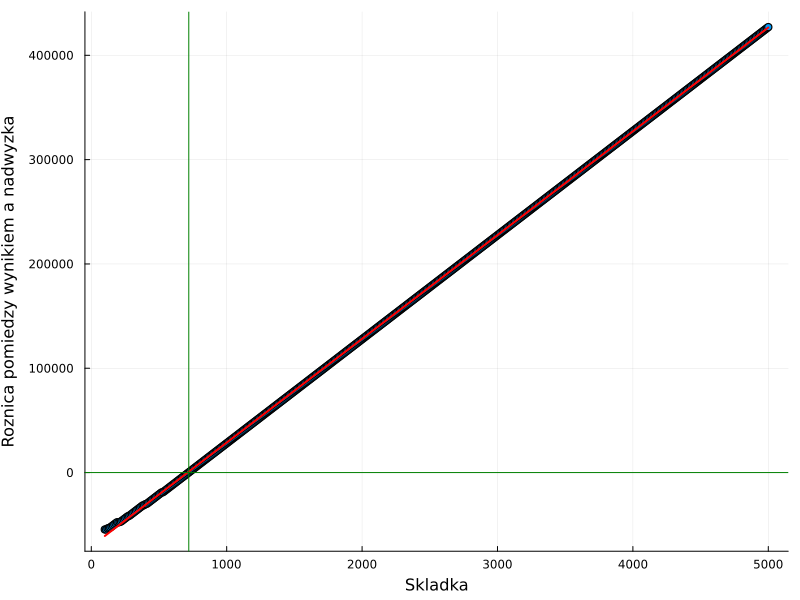

In [24]:
using Statistics
using GLM
using Plots

# Regression model
models = lm(@formula(Roznica ~ Skladka), df)

# Extracting model coefficients
intercept = coef(models)[1]
slope_skladka = coef(models)[2]

# Data chart
scatter(df.Skladka, df.Roznica, xlabel="Skladka", ylabel="Roznica pomiedzy wynikiem a nadwyzka", legend=false)

# Model values
x = minimum(df.Skladka):1:maximum(df.Skladka)
y = intercept .+ slope_skladka .* x

skladka_finalna = 0.0

# Finding the final contribution
for xx in skladki
    yy = intercept .+ slope_skladka .* xx
    if yy >= 0
        skladka_finalna = xx
        break
    end
end

println("Final contribution: ", skladka_finalna)
plot!(x, y, color=:red, linewidth=2, label="Regression model", size=plot_size)
hline!([0.0], color="green")
vline!([skladka_finalna], color="green")
plot!(formatter = :plain)

## 4. How does the number of simulations affect the results?

#### a) How the number of simulations affects premiums

In [25]:
nadwyzka = 10000.0
skladka = 500.0:20:1500.0
LICZBA_POWTORZEN = 100:50:1000

df = DataFrame(Prawd_bankr = Float64[], LICZBA_POWTORZEN = Float64[])

for skl in skladka, lb in LICZBA_POWTORZEN
    wynik = wywolanie(nadwyzka, skl, 
            lb, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)
    push!(df, (wynik.p_bankructwa, lb))
end

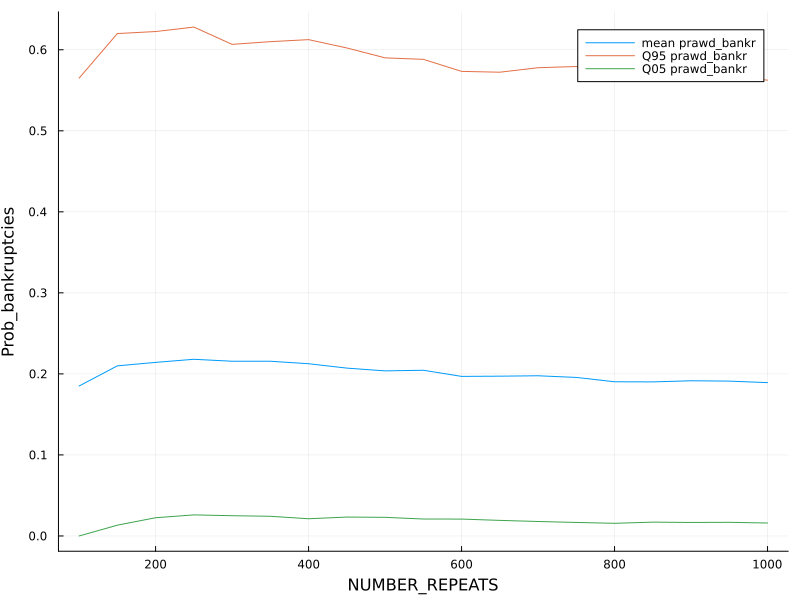

In [26]:
using DataFrames
using Statistics
using Plots

# Grouping and calculation of the average
df_quantile_prawd_bankr_95 = combine(groupby(df, :LICZBA_POWTORZEN), :Prawd_bankr => (x -> quantile(x, 0.95)) => :Prawd_bankr_quantile_95)
df_mean_prawd_bankr = combine(groupby(df, :LICZBA_POWTORZEN), :Prawd_bankr => mean)
df_quantile_prawd_bankr_05 = combine(groupby(df, :LICZBA_POWTORZEN), :Prawd_bankr => (x -> quantile(x, 0.05)) => :Prawd_bankr_quantile_05);

liczba_powtorzen = df_mean_prawd_bankr.LICZBA_POWTORZEN
prawd_bankr = df_mean_prawd_bankr.Prawd_bankr_mean

label1 ="mean prawd_bankr"
label2="Q95 prawd_bankr"
label3="Q05 prawd_bankr"
# Wykresy
plot(df_mean_prawd_bankr.LICZBA_POWTORZEN, df_mean_prawd_bankr.Prawd_bankr_mean, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label1,size=plot_size)
plot!(df_quantile_prawd_bankr_95.LICZBA_POWTORZEN, df_quantile_prawd_bankr_95.Prawd_bankr_quantile_95, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label2)
plot!(df_quantile_prawd_bankr_05.LICZBA_POWTORZEN, df_quantile_prawd_bankr_05.Prawd_bankr_quantile_05, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label3)

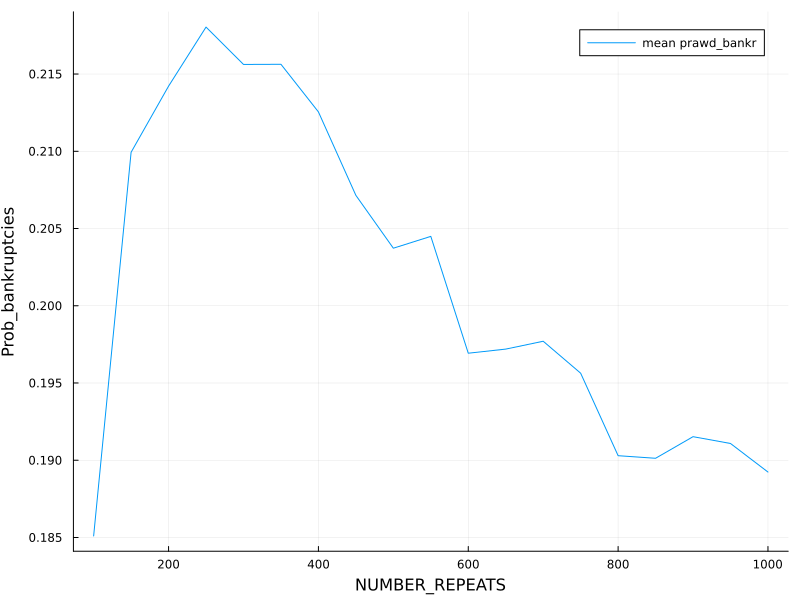

In [27]:
plot(df_mean_prawd_bankr.LICZBA_POWTORZEN, df_mean_prawd_bankr.Prawd_bankr_mean, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label1,size=plot_size)

#### b) How the number of simulations affects the surplus

In [28]:
nadwyzka = 10000.0:100.0:30000.0
skladka = 1000.0
LICZBA_POWTORZEN = 100:50:1000

df = DataFrame(Prawd_bankr = Float64[], LICZBA_POWTORZEN = Float64[])

for nd in nadwyzka, lb in LICZBA_POWTORZEN
    wynik = wywolanie(nd, skladka, 
            lb, LICZBA_KLIENTOW, 
            srednia_liczba_szkod , SR_SZKODA_LN, 
            STD_SZKODA_LN, HORYZONT)
    push!(df, (wynik.p_bankructwa, lb))
end

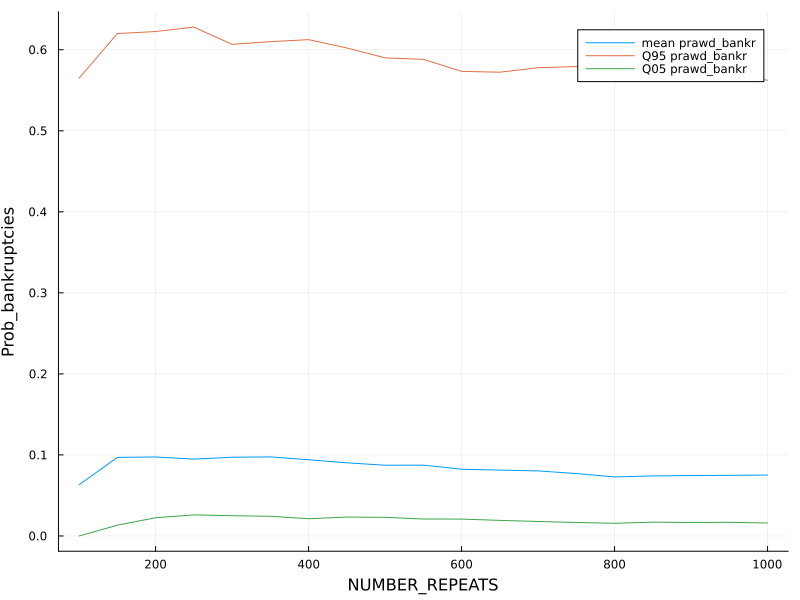

In [31]:
using DataFrames
using Statistics
using Plots

df_mean_prawd_bankr = combine(groupby(df, :LICZBA_POWTORZEN), :Prawd_bankr => mean)

liczba_powtorzen = df_mean_prawd_bankr.LICZBA_POWTORZEN
prawd_bankr = df_mean_prawd_bankr.Prawd_bankr_mean

label1 ="mean prawd_bankr"
label2="Q95 prawd_bankr"
label3="Q05 prawd_bankr"
# Wykresy
plot(df_mean_prawd_bankr.LICZBA_POWTORZEN, df_mean_prawd_bankr.Prawd_bankr_mean, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label1,size=plot_size)
plot!(df_quantile_prawd_bankr_95.LICZBA_POWTORZEN, df_quantile_prawd_bankr_95.Prawd_bankr_quantile_95, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label2)
plot!(df_quantile_prawd_bankr_05.LICZBA_POWTORZEN, df_quantile_prawd_bankr_05.Prawd_bankr_quantile_05, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label3)

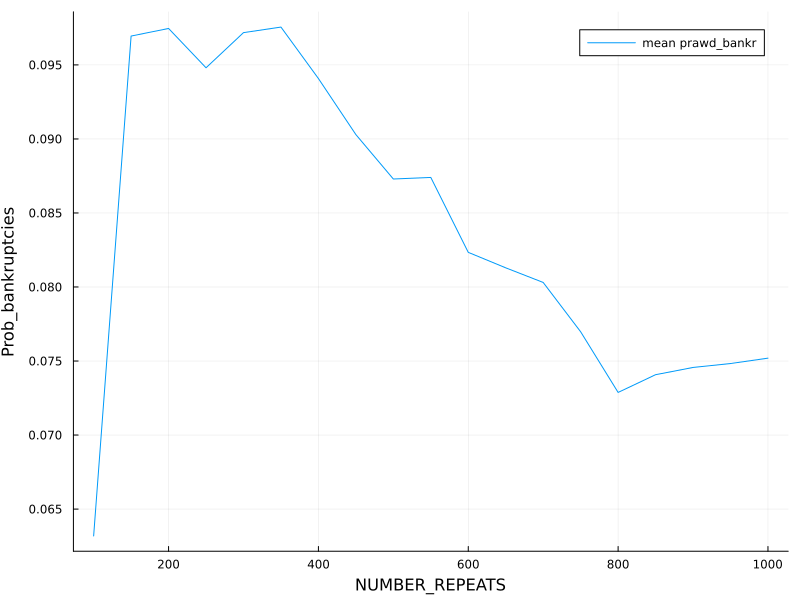

In [32]:
plot(df_mean_prawd_bankr.LICZBA_POWTORZEN, df_mean_prawd_bankr.Prawd_bankr_mean, xlabel="NUMBER_REPEATS", ylabel="Prob_bankruptcies",label=label1,size=plot_size)